In [45]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import pandas as pd
from config import pickle_file
from tqdm import tqdm
import nltk
import collections
import numpy as np
import os
import librosa

In [46]:
# 导入生成文件
with open(pickle_file, 'rb') as file:
    data = pickle.load(file)

In [47]:
keys = data.keys()
# 打印键列表
for key in keys:
    print(key)

VOCAB
IVOCAB
train
dev
test


In [48]:
print('训练集:'+str(len(data['train'])))
print('dev:'+str(len(data['dev'])))
print('test:'+str(len(data['test'])))
print('vocab_size:' + str(len(data['VOCAB'])))

训练集:120098
dev:14326
test:7176
vocab_size:4335


In [49]:
# 统计一下二元组
char_list = data['IVOCAB']
vocab_size = len(char_list)
samples = data['train']
bigram_counter = collections.Counter()
print(samples[0]['wave'])
print(samples[0]['trn'])
for sample in tqdm(samples):
    text = sample['trn']
    # text = [char_list[idx] for idx in text]
    tokens = list(text)
    bigrm = nltk.bigrams(tokens)
    bigram_counter.update(bigrm)
print(bigram_counter.most_common(10))

../dataset/data_aishell/wav\train\S0002\BAC009S0002W0122.wav
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1]


 67%|██████▋   | 80050/120098 [00:00<00:00, 113332.97it/s]

100%|██████████| 120098/120098 [00:01<00:00, 110103.25it/s]

[((24, 298), 4302), ((5, 146), 3791), ((147, 366), 3562), ((0, 138), 3247), ((0, 175), 3150), ((275, 356), 2870), ((0, 387), 2803), ((356, 68), 2790), ((0, 24), 2737), ((365, 70), 2729)]


In [50]:
# 打印一下最多的三个二元组
print(char_list[24],char_list[298])
print(char_list[5],char_list[146])
print(char_list[147],char_list[366])

中 国
市 场
公 司


In [51]:
# 将频数转为出现概率统计并保存
# temp_dict = dict()
# for key, value in bigram_counter.items():
#     temp_dict[key] = value

# print('smoothing and freq -> prob')
# bigram_freq = dict()
# # 整个的字符表
# for i in tqdm(range(vocab_size)):
#     freq_list = []
#     for j in range(vocab_size):
#         if (i, j) in temp_dict:
#             freq_list.append(temp_dict[(i, j)])
#         else:
#             # 保证每个字符对至少一次
#             freq_list.append(1)

#     freq_list = np.array(freq_list)
#     freq_list = freq_list / np.sum(freq_list)

#     assert (len(freq_list) == vocab_size)
#     bigram_freq[i] = freq_list

# print(len(bigram_freq[0]))
# with open('bigram_freq.pkl', 'wb') as file:
#     pickle.dump(bigram_freq, file)

In [52]:
# 打印一下第一个编码
print(char_list[0])

<sos>


In [53]:
# print(bigram_freq[1][1])

In [54]:
# 添加噪声
def spec_augment(spec: np.ndarray, num_mask=2, 
                 freq_masking_max_percentage=0.15, time_masking_max_percentage=0.3):

    spec = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec

In [55]:
audio_path = os.path.join("../dataset/data_aishell/wav/train/S0002/BAC009S0002W0122.wav")
sr, audio = wavfile.read(audio_path)

x = librosa.feature.melspectrogram(y=audio.astype(float), sr=sr, S=None, n_fft=512, hop_length=256, n_mels=40).T
x = librosa.power_to_db(x, ref=np.max)

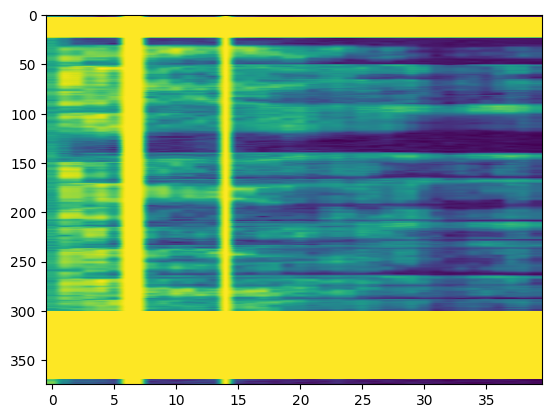

In [56]:
plt.figure()
plt.imshow(spec_augment(x),aspect= 'auto')
plt.show()

In [57]:
# 抽帧
def build_LFR_features(inputs, m, n):
    """
    Actually, this implements stacking frames and skipping frames.
    if m = 1 and n = 1, just return the origin features.
    if m = 1 and n > 1, it works like skipping.
    if m > 1 and n = 1, it works like stacking but only support right frames.
    if m > 1 and n > 1, it works like LFR.
    Args:
        inputs_batch: inputs is T x D np.ndarray
        m: number of frames to stack
        n: number of frames to skip
    """
    # LFR_inputs_batch = []
    # for inputs in inputs_batch:
    LFR_inputs = []
    T = inputs.shape[0]
    T_lfr = int(np.ceil(T / n))
    for i in range(T_lfr):
        if m <= T - i * n:
            LFR_inputs.append(np.hstack(inputs[i * n:i * n + m]))
        else:  # process last LFR frame
            num_padding = m - (T - i * n)
            frame = np.hstack(inputs[i * n:])
            for _ in range(num_padding):
                frame = np.hstack((frame, inputs[-1]))
            LFR_inputs.append(frame)
    return np.vstack(LFR_inputs)

In [58]:
audio_path = os.path.join("../dataset/data_aishell/wav/train/S0002/BAC009S0002W0122.wav")
sr, audio = wavfile.read(audio_path)

x = librosa.feature.melspectrogram(y=audio.astype(float), sr=sr, S=None, n_fft=512, hop_length=256, n_mels=40).T
x = librosa.power_to_db(x, ref=np.max)

In [59]:
feature1 = spec_augment(x)
# 明显看出n的作用
feature = build_LFR_features(feature1, m=1, n=10)

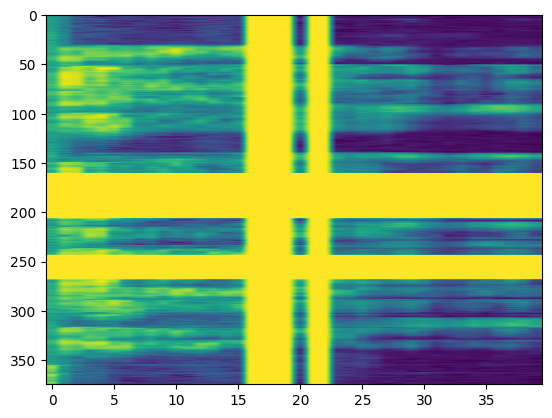

In [60]:
plt.figure()
plt.imshow(feature1,aspect= 'auto')
plt.show()

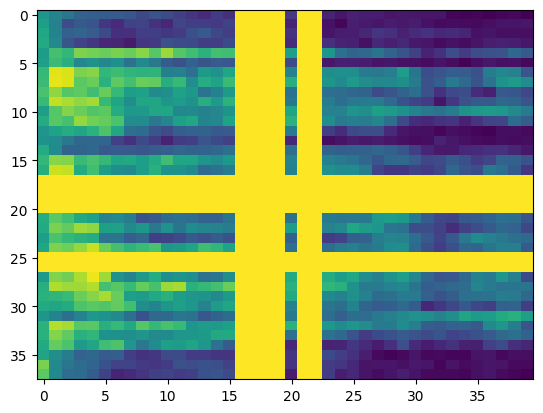

In [61]:
plt.figure()
plt.imshow(feature,aspect= 'auto')
plt.show()

测试各种训练

In [62]:
# 测试data——process
from torch.utils.data import DataLoader
import data_process
dataset=data_process.AiShellDataset('test')
first_data = dataset[0]
feature,trn=first_data

In [63]:
# 查看输入输出数据集
print(feature,trn)
print(feature.shape,len(trn))

[[-0.3262395   0.17098634  0.31233305 ... -0.7408709  -0.7317126
  -0.63851285]
 [ 0.17852771  0.13855937 -0.3834093  ... -0.685384   -0.6265054
  -0.6549062 ]
 [ 0.4784395  -0.08476716 -0.9655915  ... -0.73383915 -0.6200245
  -0.59371793]
 ...
 [ 1.4995568   1.59078     1.3565599  ... -0.8034648  -0.8160007
  -0.6473056 ]
 [ 0.35263103 -0.22914332 -0.19947994 ... -0.89558774 -0.7786102
  -0.6196669 ]
 [ 1.4995587   1.4148687   0.07129297 ... -0.8218369  -0.80060863
  -0.66357666]] [0, 1041, 1034, 90, 372, 7, 643, 1038, 1039, 699, 1460, 14, 272, 1098, 1]
(138, 320) 15


In [64]:
for i in trn:
    print(char_list[i],end="")

<sos>甚至出现交易几乎停滞的情况<eos>

In [65]:
data['test'][0]

{'trn': [0,
  1041,
  1034,
  90,
  372,
  7,
  643,
  1038,
  1039,
  699,
  1460,
  14,
  272,
  1098,
  1],
 'wave': '../dataset/data_aishell/wav\\test\\S0764\\BAC009S0764W0121.wav'}

In [66]:
from padding import pad_collate
# 填充使得每批大小一定,形成矩阵,注意是每批,批与批之间不一定大小相同
dataloader=DataLoader(dataset, batch_size=32, collate_fn=pad_collate,
                                               pin_memory=True, shuffle=True, num_workers=4)

In [23]:
datatiter=iter(dataloader)
batch=next(datatiter)
# print(batch[0])
# print(batch[1])

In [24]:
# batch[0]即输入的一批数据
print(batch[0].shape)
print(batch[1].shape)
print(batch[2])

torch.Size([32, 253, 320])
torch.Size([32, 26])
tensor([253, 250, 220, 211, 196, 195, 195, 186, 183, 175, 172, 169, 168, 162,
        159, 157, 135, 127, 125, 120, 119, 100,  95,  94,  94,  91,  90,  88,
         85,  84,  82,  74])


In [25]:
# 可以这样获取一批数据
# for i, (data) in enumerate(dataloader):
#     padded_input, padded_target, input_lengths = data
#     print(padded_input.shape)
#     print(padded_target.shape)
#     print(input_lengths)
#     break

In [26]:
from config import device
import torch
from model.PositionalEncoding import PositionalEncoding
# 卷积后的输入
d_input=159
d_model=512

In [27]:
# 输入先卷积
from model.InputEncoding import InputEncoding
conv=InputEncoding()
incov=conv.forward(batch[0])
print(incov.shape)

torch.Size([32, 126, 159])


In [28]:
import torch.nn as nn
# linear只改变最后一维,所以经过了linear层变为如下
m = nn.Linear(d_input, d_model)
IE = m(incov)
print(IE.size())

torch.Size([32, 126, 512])


In [29]:
# 尽管batch是32,每个的位置编码都是相同的,只需要编一次即可
pe=PositionalEncoding(d_model=512,max_len=5000)
PE=pe.forward(incov)
print(PE.shape)

torch.Size([1, 126, 512])


In [30]:
input_encoder=PE+IE
input_encoder.shape

torch.Size([32, 126, 512])

In [31]:
print(input_encoder.permute(1,0,2).shape)

torch.Size([126, 32, 512])


In [32]:
# ln=torch.nn.LayerNorm(d_model)
# x=ln.forward(input_encoder)
# x.shape

In [33]:
# from  model.Encoder import Encoder
# from model.InputEncoding import InputEncoding
# encoder=Encoder()
# encoder_out=encoder.forward(batch[0])
# print(encoder_out.shape)

编写解码器

In [34]:
# target
# print(batch[1])

In [35]:
# ys = [y[y != -1] for y in batch[1]]
# print(ys[1])

In [36]:
# # 确保 eos 和 sos 与 ys[0] 具有相同的数据类型和设备属性
# sos = ys[0].new([0])
# eos = ys[0].new([1])
# ignore=ys[0].new([-1])
# print(sos,eos,ignore)

In [37]:
# # 一维下dim没啥用
# ys_in = [torch.cat([sos, y], dim=0) for y in ys]
# ys_out = [torch.cat([y, ignore], dim=0) for y in ys]
# print(ys_in[1])
# print(ys_out[1])

In [38]:
# # 填充
# def pad_list(xs, pad_value):
#     n_batch = len(xs)
#     max_len = max(x.size(0) for x in xs)
#     pad = xs[0].new(n_batch, max_len, *xs[0].size()[1:]).fill_(pad_value)
#     for i in range(n_batch):
#         pad[i, :xs[i].size(0)] = xs[i]
#     return pad

In [39]:
# # 进行偏移输入,解码器的每个时间步的输出作为下一个时间步的输入
# # 这样才能预测下一个字符编码
# # 1的目的是使输入都能embedding
# in_pad = pad_list(ys_in, 1)
# out_pad = pad_list(ys_out, -1)
# for i in range (0,32):
#     print(in_pad[i])
#     print(out_pad[i])

In [40]:
# from model.GenerateOutputSeq import in_out_process
# in_pad,out_pad=in_out_process(batch[1])
# for i in range (0,32):
#     print(in_pad[i])
#     print(out_pad[i])

In [41]:
# embedding = torch.nn.Embedding(4335, 512)
# in_pad,out_pad=in_out_process(batch[1])

# OE=embedding.forward(in_pad)
# position_encoding = PositionalEncoding(d_model=512, max_len=5000)
# OPE=position_encoding.forward(in_pad)

In [42]:
# print(OE.shape,OPE.shape)

In [43]:
# outinput=OE+OPE
# print(outinput.shape)

In [44]:
from model.out_process import outprocess
out=outprocess(batch[1])
print(out)

tensor([[   0,  329,   63, 1188,  296,  365,  170,  109,  189,    6,    7,  345,
          220,  710,  360,  178,  186,  175,  275,  356,   68,  362,  154,  206,
            1,    1],
        [   0,  298,  333,  334,  298,  295, 1192,    3,  203,  293,  309,   69,
          294,  295,   14,  341,  250,  443,  270,  175, 1031, 1205,  403,  118,
            1,    1],
        [   0,  298,  295, 1192,  644,  365,  279,   66,    3,  219,  262,  286,
           75,  359,  755,  602,  298,  293,  220, 2040,   87,   57,    5,  156,
          893,    1],
        [   0,  156,  230,  147,  454,  154,  835,  830, 1498, 1360,   90,  736,
          633,  162,  835,  835,  442,   14,   50,   51,   18,  194,    1,    1,
            1,    1],
        [   0, 1469,   33,  471,  150,  151, 1152,  982,   70,  560, 2519,  301,
          852, 1077, 1356, 2019,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [   0,  783,  552,   57,   58,    6,   18,   67,  550, 2400,  313,  467,

In [67]:
from model.Transformer import Transformer
trans=Transformer()
inputs, labels = batch[0], out
y_input = labels[:,:-1]
y_expected = labels[:,1:]
sequence_length = y_input.size(1)
tgt_mask = trans.get_tgt_mask(sequence_length)
outputs = trans.forward(inputs, y_input, tgt_mask)
print(outputs.shape)

torch.Size([32, 25, 4335])


In [47]:
print(outputs)

tensor([[3828., 1836.,  331., 2182., 1737.,  546., 3330., 2127., 3624.,  710.,
         4281.,  880., 2758., 2931., 3330., 1737., 2931., 2182., 2248., 3461.,
          185., 1278., 2703., 4281.],
        [4031., 1984., 2560., 3828., 2578., 3828.,  361.,  351., 3208., 1966.,
         2574., 1737., 2560., 3208.,  880., 3808., 4281., 4281.,    6., 2269.,
          581., 1628., 1344., 4281.],
        [ 890., 4233., 3010., 2931., 2758., 2182.,  745., 1278., 4281.,  581.,
         2931., 2127., 1344.,  700., 4281., 3461., 1499., 4334., 3540., 3208.,
         3208., 3394., 4281., 4281.],
        [2931., 2560., 4210., 2219., 2619.,  279., 2758., 4281., 2619., 2703.,
         2619., 3828., 3717., 2931., 1670.,  880., 2560.,   90.,  880., 3694.,
          279.,  880., 3694., 1344.],
        [2931.,  414., 4065., 3828., 2560.,  297.,  880.,  700., 2931., 2560.,
          648., 1737., 1984., 3285.,    6., 1737., 2361., 1091., 2182., 2931.,
         4281., 1922., 1988., 2946.],
        [ 279.,  948

In [48]:
y_expected

tensor([[  24,  298, 1049,  207,  300,  180,  326,   14,   40,  992,  256,  400,
          113,   71,  107,   54,  395,   18,  112, 1079,   14,  311, 1695,    1],
        [ 306,  692, 1188,  187,   45,  423,  285,  935,  209,  149, 2431,  252,
           18, 1862, 1990,  483, 1061,   14,   47,   48,  262,  372,    1,    1],
        [ 499,  405,    5,  146,  191,  722,  324,  332,  362,  354,  276,  277,
          278,  555,  555,  167,  223, 1038,   48,   28,    1,    1,    1,    1],
        [  24, 1548,  370,  371, 1566,  270,  294,  295,   63,  276,  278,    3,
          842, 1838, 1702,   24,  200,   45,  132,  117,  422,  232,    1,    1],
        [ 642, 1966,  147,  366,   14,   59,  987,  512, 2960,  149,  772,  523,
          465,  608,   14,  225,  226,  206,  561,    1,    1,    1,    1,    1],
        [1192,  834,  207,  154,   86,  165,  107,   14,  295,   81,  233,  737,
           47,   48,  480,   47,  295,   81,  246,  834,    1,    1,    1,    1],
        [ 450,  357,  